In [1]:
#Partially adopted from Tensorflow/docs/basic_text_classification
#https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/basic_text_classification.ipynb

#As well as https://developers.google.com/machine-learning/guides/text-classification/

In [2]:
import tensorflow as tf
from tensorflow import keras

from sklearn.utils import shuffle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

import numpy as np
import pandas as pd

from data import Data, TestData, WikiData

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
data = []
noise = []
with open('Data/NFR.csv') as f:
    # Create two instances of data: fake (noise) and real (data)
    for sentence in f:
        cl = sentence[:sentence.find(',')]
        sentence = sentence[sentence.find(',')+1:]
        if cl == 'Security':
            data.append(sentence)
        else:
            noise.append(sentence)

# Create two instances of data from fake and real
test_0 = TestData(noise, '0')
test_1 = TestData(data, '1')

# Balance the data based on min length of both lists
deleteAfter = min(len(test_0.data), len(test_1.data))
del test_0.data[deleteAfter:]
del test_1.data[deleteAfter:]
del test_0.labels[deleteAfter:]
del test_1.labels[deleteAfter:]

# Test that the data is balanced
assert len(test_0.data) == len(test_1.data), 'Lengths of test datas are not equal'
assert len(test_0.labels) == len(test_1.labels), 'Lengths of test labels are not equal'
assert len(test_0.data) == len(test_0.labels), 'Lengths of test data and labels do not match'
assert len(test_1.data) == len(test_1.labels), 'Lengths of test data and labels do not match'

Labels made successfully
Labels made successfully


In [4]:
# Get train data from Wiki articles
train_0 = WikiData(articlesFile='Data/enwiki-latest-all-titles-in-ns0', keyword='rand', size=500, labelValue='0')
train_1 = WikiData(articlesFile='Data/enwiki-latest-all-titles-in-ns0', keyword='security', size=500, labelValue='1')

Article names in random list: 500
Labels made successfully
Article names in the security list: 500
Labels made successfully


In [5]:
# Balance the data based on min length of both lists
deleteAfter = min(len(train_0.data), len(train_1.data))

# If min length is less than 100 sentences, test is invalid
assert deleteAfter > 100, 'Train set is too small'

del train_0.data[deleteAfter:]
del train_1.data[deleteAfter:]
del train_0.labels[deleteAfter:]
del train_1.labels[deleteAfter:]

# Test that the data is balanced
assert len(train_0.data) == len(train_1.data), 'Lengths of train datas are not equal'
assert len(train_0.labels) == len(train_1.labels), 'Lengths of train labels are not equal'
assert len(train_0.data) == len(train_0.labels), 'Lengths of train data and labels do not match'
assert len(train_1.data) == len(train_1.labels), 'Lengths of train data and labels do not match'

#Collapse into single list
trainData = train_0.data + train_1.data
trainLabels = train_0.labels + train_1.labels
x_test = test_0.data + test_1.data
y_test = test_0.labels + test_1.labels

#Shuffle two lists, save the order
trainData, trainLabels = shuffle(trainData, trainLabels)
x_test, y_test = shuffle(x_test, y_test)

#Get validation data
validationToTrainRatio = 0.05
validationSize = int(validationToTrainRatio * len(trainData))
validationData = trainData[:validationSize]
validationLabels = trainLabels[:validationSize]
trainData = trainData[validationSize:]
trainLabels = trainLabels[validationSize:]


print("\nTest set length: %d" % len(x_test))
print("Test labels set length: %d" % len(y_test))
print("\nValidation set length: %d" % len(validationData))
print("Validation labels set length: %d" % len(validationLabels))
print("\nTrain set length: %d" % len(trainData))
print("Train labels set length: %d" % len(trainLabels))


Test set length: 708
Test labels set length: 708

Validation set length: 2248
Validation labels set length: 2248

Train set length: 42722
Train labels set length: 42722


In [6]:
# Vectorizing train, validation, and test data
trainData = train_0.ngram_vectorize(data=trainData, labels=trainLabels)

validationData = train_0.ngram_vectorize(
    data=validationData,
    vectorizer=train_0.vectorizer, 
    selector=train_0.selector)

x_test = train_0.ngram_vectorize(
    data=x_test,
    vectorizer=train_0.vectorizer, 
    selector=train_0.selector)

In [7]:
# Binary classifier (model) construction method
def mlp_model(layers, units, dropout_rate, input_shape, num_classes):
    model = keras.Sequential()
    model.add(keras.layers.Dropout(rate=dropout_rate, input_shape=input_shape))
    for _ in range(layers-1):
        model.add(keras.layers.Dense(units=units, activation=tf.nn.relu))
        model.add(keras.layers.Dropout(rate=dropout_rate))

    model.add(keras.layers.Dense(units=32, activation=tf.nn.relu))
    model.add(keras.layers.Dropout(rate=dropout_rate))
    model.add(keras.layers.Dense(units=num_classes, activation=tf.nn.sigmoid))
    return model

In [8]:
# For parameters refer to the upper cell
model = mlp_model(2, 64, 0.3, trainData.shape[1:], 1)
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 20000)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                1280064   
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)      

In [9]:
# Learning rate could be further decreased for additional accuracy
model.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [10]:
# Callbacks will prevent model from running if val_loss starts to increase
callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2)]

# Training the classifier (model)
history = model.fit(trainData,
                    trainLabels,
                    epochs=20,
                    callbacks=callbacks,
                    batch_size=1024,
                    validation_data=(validationData, validationLabels),
                    verbose=2)

Train on 42722 samples, validate on 2248 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
 - 32s - loss: 0.6249 - acc: 0.7819 - val_loss: 0.4863 - val_acc: 0.8603
Epoch 2/20
 - 31s - loss: 0.3863 - acc: 0.8677 - val_loss: 0.2877 - val_acc: 0.8901
Epoch 3/20
 - 31s - loss: 0.2663 - acc: 0.8944 - val_loss: 0.2320 - val_acc: 0.9070
Epoch 4/20
 - 33s - loss: 0.2265 - acc: 0.9079 - val_loss: 0.2159 - val_acc: 0.9181
Epoch 5/20
 - 33s - loss: 0.2111 - acc: 0.9131 - val_loss: 0.2112 - val_acc: 0.9159
Epoch 6/20
 - 30s - loss: 0.1961 - acc: 0.9189 - val_loss: 0.2119 - val_acc: 0.9124
Epoch 7/20
 - 29s - loss: 0.1882 - acc: 0.9204 - val_loss: 0.2090 - val_acc: 0.9110
Epoch 8/20
 - 29s - loss: 0.1819 - acc: 0.9236 - val_loss: 0.2093 - val_acc: 0.9141
Epoch 9/20
 - 29s - loss: 0.1802 - acc: 0.9231 - val_loss: 0.2053 - val_acc: 0.9173
Epoch 10/20
 - 29s - loss: 0.1732 - acc: 0.9245 - val_loss: 0.2051 - val_acc: 0.9141
Epoch 11/20
 - 29s - loss: 0.1696 - acc: 0.9264 - val_loss: 0.

In [13]:
# Calculating results
results = model.predict(x_test)
pred_labels = []
occurences = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
for x in results:
    if x <= 0.05:
        occurences[0] += 1
        pred_labels.append(0)
    elif x <= 0.15 and x > 0.05:
        occurences[1] += 1
        pred_labels.append(0)
    elif x <= 0.25 and x > 0.15:
        occurences[2] += 1
        pred_labels.append(0)
    elif x <= 0.35 and x > 0.25:
        occurences[3] += 1
        pred_labels.append(0)
    elif x <= 0.45 and x > 0.35:
        occurences[4] += 1
        pred_labels.append(0)
    elif x <= 0.55 and x > 0.45:
        occurences[5] += 1
        pred_labels.append(0)
    elif x <= 0.65 and x > 0.55:
        occurences[6] += 1
        pred_labels.append(0)
    elif x <= 0.75 and x > 0.65:
        occurences[7] += 1
        pred_labels.append(0)
    elif x <= 0.85 and x > 0.75:
        occurences[8] += 1
        pred_labels.append(0)
    elif x <= 0.95 and x > 0.85:
        occurences[9] += 1
        pred_labels.append(0)
    elif x <= 0.98 and x > 0.95:
        occurences[10] += 1
        pred_labels.append(1)
    elif x > 0.98:
        occurences[11] += 1
        pred_labels.append(1)

TP = 0
TN = 0
FP = 0
FN = 0
for x, y in zip(pred_labels, y_test):
    if x == 1 and y == 1:
        TP += 1
    elif x == 1 and y == 0:
        FP += 1
    elif x == 0 and y == 1:
        FN += 1
    elif x == 0 and y == 0:
        TN += 1

[10, 18, 15, 17, 12, 24, 25, 48, 75, 120, 99, 245]
Accuracy: 0.7825

Precision: 0.7907
Recall: 0.7684
F-score: 0.7794

TP 272, TN 282, FP 72, FN 82


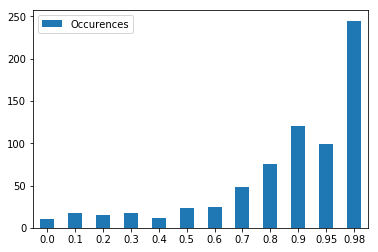

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print(occurences)
accuracy = accuracy_score(y_test, pred_labels)
precision = precision_score(y_test, pred_labels)
recall = recall_score(y_test, pred_labels)
fscore = f1_score(y_test, pred_labels)
print("Accuracy: %.4f" % accuracy)
print("\nPrecision: %.4f\nRecall: %.4f\nF-score: %.4f" % (precision, recall, fscore))
print("\nTP %d, TN %d, FP %d, FN %d" % (TP, TN, FP, FN))

df = pd.DataFrame({'Occurences': occurences}, index=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.98])
ax = df.plot.bar(rot=0)